# Generator of random plots

In [1]:
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
dim_x = 250 # Maximum value of x
dim_y = 250 # Maximum value of y
n_knots = 2 # Number of "internal"knots, i.e. knots excluding boundary knots
n_samples = 60000

### Creating an array with coordinates of knots

The first half of columns are xs; the second, ys. X and y coordinates are in the same dimension to use the apply_along_axis function below. Rows are samples. X coordinates must be a strictly increasing sequence and include endpoints.

Function to create a 1D array with knot coordinates for a given number of knots.

In [3]:
def random_knots(n_knots):
    knots_y = np.random.randint(low = 1, 
                                high = dim_y, 
                                size = (n_knots + 2),
                               dtype=np.int16)

    knots_x = np.random.choice(np.arange(1, dim_x, dtype=np.int16), 
                                size = (n_knots), 
                                replace=False)
    knots_x.sort(axis=0) # Values of x need to be ordered for cubic interpolation.

    knots_all = np.concatenate(
        (np.array([0], dtype=np.int16),
         knots_x,
         np.array([dim_x], dtype=np.int16),
         knots_y), 
        axis=0)
    return knots_all

Creating the knots array:

In [4]:
knots_all = np.apply_along_axis(random_knots,
                                1, 
                                np.full ((n_samples,1), 2, dtype=np.int16)
                               )

In [5]:
knots_all[0:5, :]

array([[  0,  55,  60, 250, 222,   8,  37, 211],
       [  0,  28, 163, 250,  97, 210,   4, 234],
       [  0,  60, 210, 250,  41,  54, 144,  16],
       [  0,  22, 108, 250,  54, 224, 122,  81],
       [  0,  34, 247, 250, 235, 187, 128, 170]], dtype=int16)

x coordinates of knots:

In [6]:
knots_all[0:5, 0:(n_knots+2)]

array([[  0,  55,  60, 250],
       [  0,  28, 163, 250],
       [  0,  60, 210, 250],
       [  0,  22, 108, 250],
       [  0,  34, 247, 250]], dtype=int16)

y coordinates of knots:

In [7]:
knots_all[0:5, (n_knots+2) : ((n_knots + 2) * 2)]

array([[222,   8,  37, 211],
       [ 97, 210,   4, 234],
       [ 41,  54, 144,  16],
       [ 54, 224, 122,  81],
       [235, 187, 128, 170]], dtype=int16)

Function generating a random function. Its domain is [0, dim_x]. The function produces an array of function values of size (dim_x) using cubic spline interpolation for given knots.

In [8]:
def random_function(knots):
    x = np.arange(dim_x + 1)
    cs = CubicSpline(knots[0:(n_knots+2)], knots[(n_knots+2) : ((n_knots + 2) * 2)])
    y = cs(x)
    if y.max() - y.min() >= dim_y:
        y = y * dim_y /(y.max() - y.min())
    if y.max() >= dim_y:
        y -= y.max() - dim_y
    elif y.min() <= 0:
        y -= y.min()
    return y 

In [9]:
curves = np.apply_along_axis(random_function, 1, knots_all)

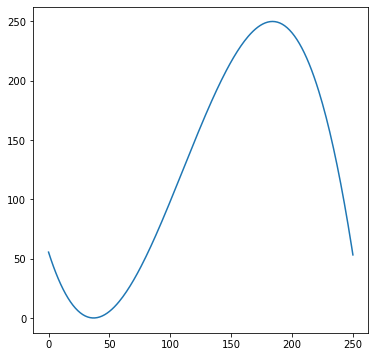

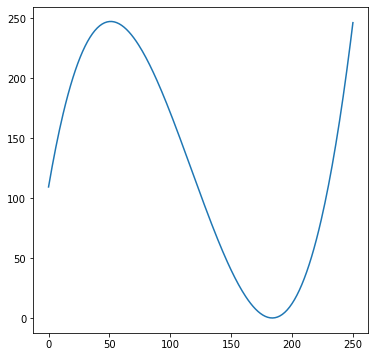

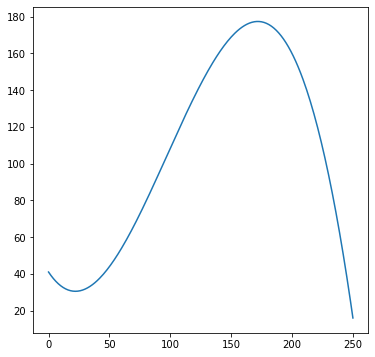

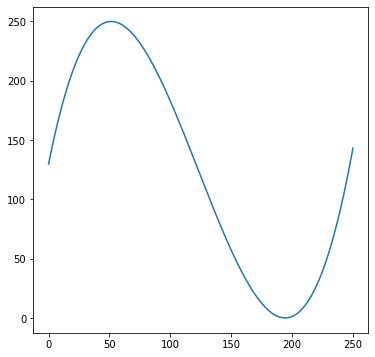

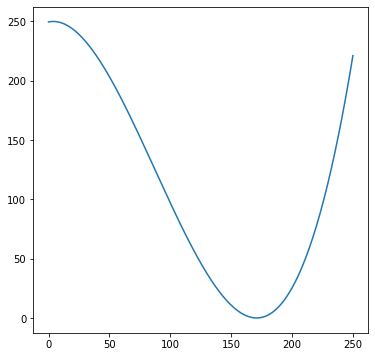

In [10]:
for n in range(5):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(np.arange(dim_x + 1), curves[n,:])

Function to produce an array with random plots. Each sample is a plot of a given random function (input variable) with a random grid. Number of grid lines along x and y is different and is selected randomly from an interval from 1 (one grid line in the center of the plot plus lines on the sides) to 8.

In [11]:
def random_plot(curve):
    ngrid_x = random.randint(1, 8)
    ngrid_y = random.randint(1, 8)
    grid_coord_x = [int(i * dim_x / (ngrid_x + 1)) for i in range(ngrid_x + 2)]
    grid_coord_y = [int(i * dim_y / (ngrid_y + 1)) for i in range(ngrid_y + 2)]
    plot = np.zeros(shape=(dim_y + 1, dim_x + 1), dtype=np.int16)
    plot[:, grid_coord_x] = 1
    plot[grid_coord_y, :] = 1
    plot[curve.astype(np.int16), np.arange(dim_x + 1)] = 1
    return plot

In [12]:
plots = np.apply_along_axis(random_plot, 1, curves)

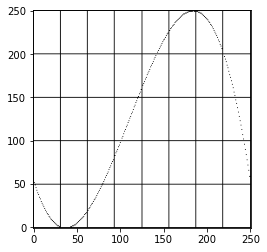

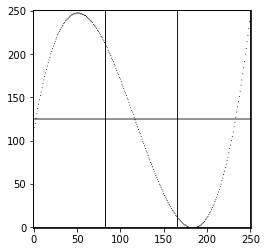

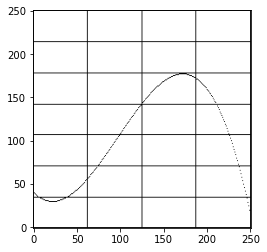

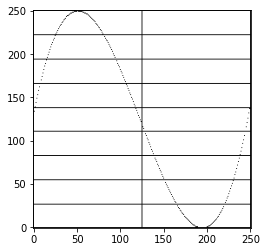

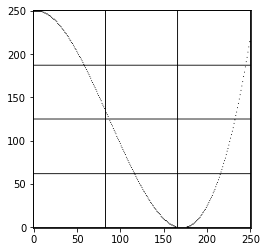

In [13]:
for n in range(5):
    plt.imshow(plots[n, :, :], cmap='gray_r', vmin=0, vmax=1, origin='lower')
    plt.show()

In [15]:
np.save('E:\MyCode\Portfolio\PlotRecognition\curves.npy', curves)

In [16]:
np.save('E:\MyCode\Portfolio\PlotRecognition\plots.npy', plots)